In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
train_ds = pd.read_csv('/content/drive/My Drive/Colab Notebooks/digit-recognizer/train.csv')

In [3]:
train_ds.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
labels = train_ds.label

In [5]:
labels.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [6]:
img = train_ds.drop(labels='label' ,axis=1)

In [7]:
img.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
X = img.to_numpy()
Y = labels.to_numpy()

In [9]:
import matplotlib.pyplot as plt

In [10]:
# reshape X to (m, 28, 28)

X = X.reshape(X.shape[0], 28, 28, 1) / 255.

In [11]:
Y_onehot = np.zeros((int(Y.size), int(Y.max()) + 1))
Y_onehot[np.arange(Y.size), Y.astype(int)] = 1
print(Y_onehot.T.shape)

(10, 42000)


In [12]:
print(Y_onehot[:, 0])
print(Y[0])

[0. 1. 0. ... 0. 0. 0.]
1


In [13]:
# split train and test size about 5%

split_size = 0.05

X_test = X[0: int(X.shape[0]*split_size),:,:]
Y_test = Y_onehot[0: int(Y_onehot.shape[0]*split_size), :]

X_train = X[int(X.shape[0]*split_size): X.shape[0], :,:]
Y_train = Y_onehot[int(Y_onehot.shape[0]*split_size): Y_onehot.shape[0], : ]

print("X original size: {}, Y original Sizee: {} \n"
      "Train: X --> {} Y --> {} \nTest:  X --> {} "
      " Y --> {} \n".format(X.shape, Y.shape, X_train.shape, 
                           Y_train.shape, X_test.shape, Y_test.shape))

X original size: (42000, 28, 28, 1), Y original Sizee: (42000,) 
Train: X --> (39900, 28, 28, 1) Y --> (39900, 10) 
Test:  X --> (2100, 28, 28, 1)  Y --> (2100, 10) 



In [14]:
X_val = X_train[-3900:]
Y_val = Y_train[-3900:]

X_train = X_train[:-3900]
Y_train = Y_train[:-3900]

print("Train: X --> {} Y --> {} \nVal:  X --> {} "
      " Y --> {} \n".format(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape))

Train: X --> (36000, 28, 28, 1) Y --> (36000, 10) 
Val:  X --> (3900, 28, 28, 1)  Y --> (3900, 10) 



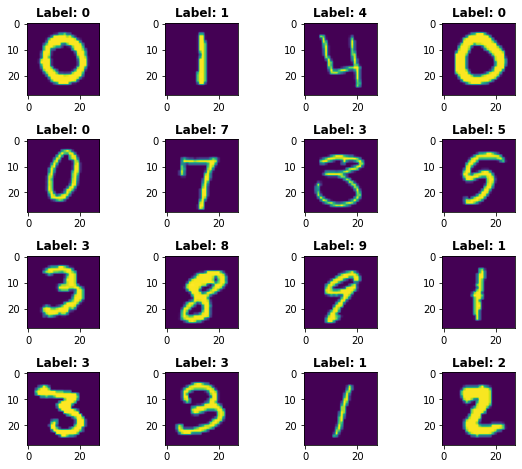

In [15]:
# img shape = 28x28x1
columns = 4
rows = 5
fig = plt.figure(figsize=(8, 8))

for index in range(1, 17):
    fig.add_subplot(rows, columns, index).set_title("Label: " + str(Y[index]), fontweight='bold')
    plt.tight_layout()
    plt.imshow(X[index].reshape(28, 28))



[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


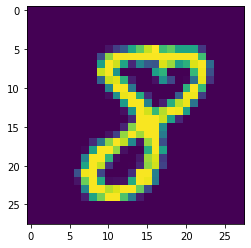

In [16]:
np.set_printoptions(threshold=np.inf)
plt.imshow(X_train[0, :, :, 0])
print(Y_train[0, :])

In [17]:

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, Input, Dense, MaxPool2D,
                                     BatchNormalization, Activation, 
                                     Add, ZeroPadding2D, Flatten, AveragePooling2D)
from tensorflow.keras.models import Model


# In[2]:


def plain_network(X, filters):
    
#     we have to save x
    x_shortcut = X
    
#     first block
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', strides=(1, 1))(X)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
#     second bloack
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
                   
#     shortcut
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
                   
    return x
    
    


# In[3]:


def residual(X, filters):
    
    x_shortcut = X
    
#     first block
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', strides=(2, 2))(X)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
#     second block
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
#     shortcut
    x_shortcut = Conv2D(filters=filters, kernel_size=(1,1), padding='valid', strides=(2, 2))(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    
#     add

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x


# In[5]:


def resnet18(input_shape):
    
    input_in = Input(shape=(input_shape))
    x = ZeroPadding2D(padding=(3,3))(input_in)
    
#   1st stage
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
    
#   2st stage
    x = plain_network(x, 64)
    x = plain_network(x, 64)
    
#   3st stage
    x = residual(x, 128)
    x = plain_network(x, 128)
    
#   4st stage
    x = residual(x, 256)
    x = plain_network(x, 256)
    
#   5st stage
    x = residual(x, 512)
    x = plain_network(x, 512)
    
#   6st stage

    x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(10, activation='softmax')(x)
    
    model = Model(inputs = input_in, outputs = x, name='resnet18')
    
    return model

# In[ ]:






In [18]:
hyperparameters = {
    "lr":0.001,
    "batch_size":256,
    "num_epoch": 20
    
}

In [19]:

model = resnet18(X.shape[1:])
optimizer = tf.keras.optimizers.Adam(learning_rate= hyperparameters["lr"])
model.compile(loss = 'categorical_crossentropy',
         optimizer = optimizer,
         metrics = ['acc'])

def lr_decay(epoch, lr):
  if epoch != 0:
    if epoch%15 == 0:
      lr = lr/100
    elif epoch%5 == 0:
      lr = lr/10
      print('Epoch: {} e Lr: {}'. format(epoch, lr))
    else:
      lr
      print('Epoch: {} e Lr: {}'. format(epoch, lr))
  else:
    print('Epoch: {} e Lr: {}'. format(epoch, lr))
  return lr

lr_schedule_decay = tf.keras.callbacks.LearningRateScheduler(
    lr_decay)

#treinamento do modelo
history = model.fit(X_train, Y_train, batch_size=hyperparameters["batch_size"],
                     epochs = hyperparameters["num_epoch"],
                     validation_data=(X_val, Y_val),
                     callbacks=[lr_schedule_decay],
                     verbose = 1,
                  )

Epoch 1/20
Epoch: 0 e Lr: 0.0010000000474974513
141/141 [==============================] - 13s 52ms/step - loss: 0.1879 - acc: 0.9472 - val_loss: 6.3480 - val_acc: 0.1118
Epoch 2/20
Epoch: 1 e Lr: 0.0010000000474974513
141/141 [==============================] - 6s 41ms/step - loss: 0.0577 - acc: 0.9822 - val_loss: 5.1159 - val_acc: 0.2418
Epoch 3/20
Epoch: 2 e Lr: 0.0010000000474974513
141/141 [==============================] - 6s 41ms/step - loss: 0.0386 - acc: 0.9876 - val_loss: 2.1009 - val_acc: 0.5877
Epoch 4/20
Epoch: 3 e Lr: 0.0010000000474974513
141/141 [==============================] - 6s 40ms/step - loss: 0.0304 - acc: 0.9906 - val_loss: 0.1454 - val_acc: 0.9585
Epoch 5/20
Epoch: 4 e Lr: 0.0010000000474974513
141/141 [==============================] - 6s 40ms/step - loss: 0.0217 - acc: 0.9932 - val_loss: 0.0824 - val_acc: 0.9754
Epoch 6/20
Epoch: 5 e Lr: 0.00010000000474974513
141/141 [==============================] - 6s 40ms/step - loss: 0.0084 - acc: 0.9974 - val_loss: 0.0

In [20]:
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
9/9 [==============================] - 0s 52ms/step - loss: 0.0175 - acc: 0.9948
test loss, test acc: [0.01752666011452675, 0.9947618842124939]


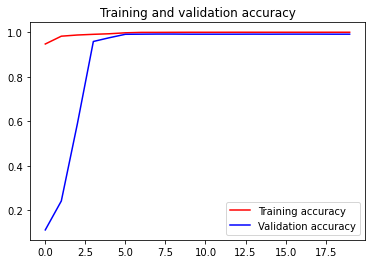

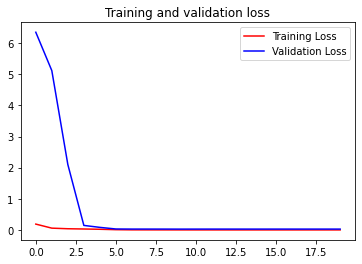

In [21]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
# Load test data

test_ds = pd.read_csv('/content/drive/My Drive/Colab Notebooks/digit-recognizer/test.csv')
test_ds.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
X_submit = test_ds.to_numpy() / 255.
X_submit = X_submit.reshape(X_submit.shape[0], 28, 28, 1)
print(X_submit.shape)

(28000, 28, 28, 1)


In [24]:
predictions = model.predict(X_submit)

In [25]:
predictions[3]

array([8.76031995e-01, 7.18809247e-07, 1.38429441e-02, 2.35191255e-05,
       1.54845438e-05, 2.16295502e-05, 9.04906483e-06, 3.22353408e-05,
       7.17979332e-04, 1.09304406e-01], dtype=float32)

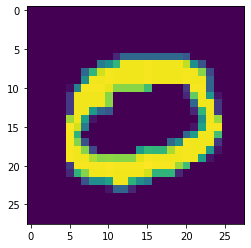

In [26]:
plt.imshow(X_submit[1, :, :, 0])

In [27]:


sample = np.argmax(predictions, axis=1)
sample_submit = pd.DataFrame(sample, columns=["Label"])
imageId = pd.DataFrame(sample_submit.index, columns=["ImageId"])
sample_submit.insert(0, "ImageId", imageId)
sample_submit.ImageId += 1
print(sample_submit.head())

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3


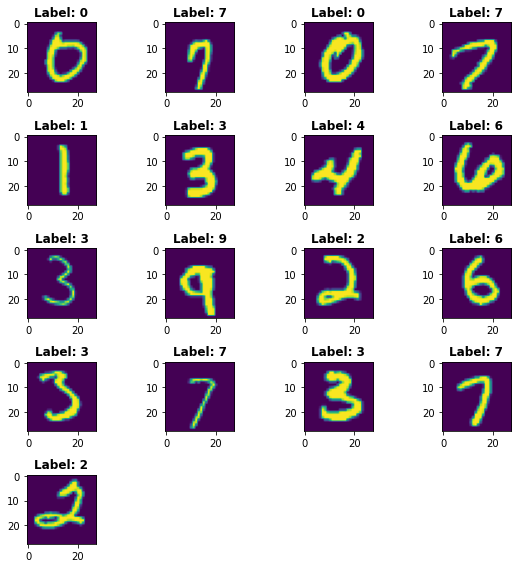

In [28]:
columns = 4
rows = 5
fig = plt.figure(figsize=(8, 8))
i = 1

for index in range(1000, 1017):
    fig.add_subplot(rows, columns, i).set_title("Label: " + str(sample_submit.Label[index]), fontweight='bold')
    plt.tight_layout()
    plt.imshow(X_submit[index, :, :, 0])
    i += 1


In [29]:
sample_submit.to_csv("submission.csv", index=False)